Import packages

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import cv2
import glob
import scipy
from scipy import ndimage

Help functions

In [2]:
# gaussian kernel
def Gauss_kernel(sigma=1):
    h1 = 5
    h2 = 5
    x, y = np.mgrid[0:h1, 0:h2]
    x = x-h1/2
    y = y-h2/2
    g = np.exp(-(x**2 + y**2) / (2*sigma**2))
    return g / g.sum()

    
# divergence    
def div(sx, sy):
    nx, junk = np.gradient(sx)
    junk, ny = np.gradient(sy)
    return nx+ny


# zeros crossing
def zerocrossing(contour):
    out = list()
    for i in range(np.shape(contour)[0]-1):
        for j in range(np.shape(contour)[1]-1):
            if (contour[i, j] > 0) and ((contour[i-1, j]*contour[i+1, j] < 0) or (contour[i, j-1]*contour[i, j+1] < 0)):
                out.append([i, j])
    out = np.asarray(out)
    return out


# delete duplicates from list
def unique(iner):
    output = list()
    for i in iner:
        if i not in output:
            output.append(i)   
    return output


# define pixel intensity threshold based on cut-off threshold or ratio threshold
def thresholding(pic, expert, value):
    if expert == 0:
        threshold = value
    elif expert == 1:
        img = pic.flatten()
        img = np.sort(img)
        threshold = img[int(len(img)*value)]
    return threshold


# decide whether use y=kx+b or x=ky+b by performing least square
def lineardecision(x, y):
    p1 = np.polyfit(x, y, 1)
    _y = np.polyval(p1, x)
    error1 = np.sum((y-_y)**2)
    p2 = np.polyfit(y, x, 1)
    _x = np.polyval(p2, y)
    error2 = np.sum((x-_x)**2)
    if error1 <= error2:
        flag = 1
        return [flag, p1]
    else:
        flag = 2
        return [flag, p2]


# level-set method function
def levelset(dt, I, box, max_iter, flag):
    c0 = 5*flag
    row, col = I.shape
    phi = c0 * np.ones((row, col))
    phi[box > 0] = -c0
    area_record = list()
    phi_record = list()

    # calculate edge indicator g
    G = Gauss_kernel()
    conv = signal.convolve(I, G, mode='same')
    Ix, Iy = np.gradient(conv)
    g = 1 / (1 + Ix ** 2 + Iy ** 2)
    gx, gy = np.gradient(g)

    # level-set evolution
    for i in range(max_iter):
        # gradient of phi
        gradphix, gradphiy = np.gradient(phi)
        # magnitude of gradient of phi
        absgradphi = np.sqrt(gradphix ** 2 + gradphiy ** 2)

        part1 = g * div(gradphix, gradphiy)
        part2 = gx * gradphix + gy * gradphiy
        part3 = g * absgradphi
        L = part1 + part2 + part3
        phi = phi + dt * L
        if (i % 10 == 0):
            area_record.append(np.sum(phi > 0))
            phi_record.append(phi)

    area_record = np.asarray(area_record)
    da = (area_record[1:] - area_record[:-1]) / area_record[:-1]
    ind = np.max(np.argpartition(da, 5)[:5])
    phi = phi_record[ind]
    phi[phi >= 0] = 0
    phi[phi < 0] = -1
    label, num_features = ndimage.label(phi)
    result = list()
    for i in range(1, num_features + 1):
        temp = np.sum(label == i)
        result.append(temp)

    n = np.argmax(result) + 1
    label[label == n] = -1
    label[label >= 0] = 1

    return label

Image preprocessing

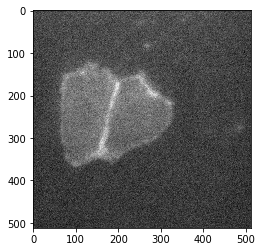

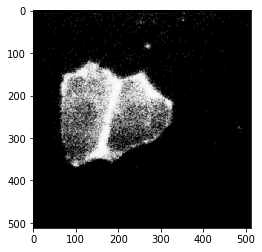

In [3]:
# read images
filenames = glob.glob('RFP sequence/*.tif')
filenames.sort()

# pick slice
n = 1
I = plt.imread(filenames[n])
plt.imshow(I, 'gray')

# preprocessing
I = I / np.max(I) * 255
I2 = np.copy(I)
I[I < (np.min(I)/0.917)] = 0
G = Gauss_kernel()
I = signal.convolve(I, G, mode='same')
plt.figure()
plt.imshow(I, 'gray')
plt.show()
np.save('middle-act/preprocessing.npy', I)
np.save('middle-act/sample.npy', I2)

The gameboard here is to manually initialize the starting box
in order to avoid the noise which cannot be removed automatically

In [4]:
%matplotlib tk

class board:
    def __init__(self, image):
        self.flag = 0
        self.image = image
        self.plist = list()
        self.fig = plt.figure()
        plt.imshow(image, cmap='bone')
        self.fig.canvas.mpl_connect('button_press_event', self.onpress)
        self.fig.canvas.mpl_connect('button_release_event', self.onrelease)
        self.fig.canvas.mpl_connect('motion_notify_event', self.onmotion)

    def onpress(self, event):
        if (event.button == 1):
            self.flag = 1
        if (event.button == 3):
            self.flag = 2
        
    def onrelease(self, event):
        self.flag = 0
    
    def onmotion(self, event):
        if self.flag == 1:
            self.plist.append([int(event.xdata), int(event.ydata)])
            self.update()
            
        if self.flag == 2:
            try:
                self.plist.remove([int(event.xdata), int(event.ydata)])
                self.update()
            except:
                pass
                                                  
    def getpoint(self):
        return self.plist
        
    def update(self):
        plt.cla()
        plt.xticks(range(0, 1000, 50))
        plt.yticks(range(0, 1000, 50))
        plt.imshow(self.image, cmap='bone')
        tx = [i[0] for i in self.plist] 
        ty = [i[1] for i in self.plist]
        plt.plot(tx, ty, 'ro')
        self.fig.canvas.draw()

I = np.load('middle-act/preprocessing.npy')
TEST = board(I)
plt.show()
point = TEST.getpoint()

C:\Users\wangj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys
C:\Users\wangj\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\wangj\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


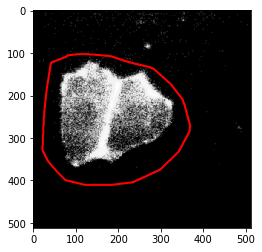

In [5]:
%matplotlib inline

point = np.asarray(point)
mask = np.zeros(I.shape)
contour = cv2.drawContours(mask,[point],0,255,-1)
plt.imshow(I, 'gray')
plt.hold(True)
plt.contour(contour, 1, colors='r',linewidths=2)
np.save('middle-act/gameboard.npy', contour)

Boundary detection of the cluster

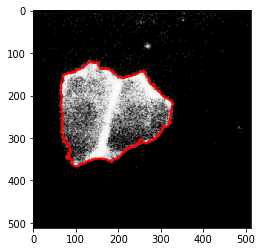

In [6]:
I = np.load('middle-act/preprocessing.npy')
box = np.load('middle-act/gameboard.npy')

# level-set evolution
label = levelset(1, I, box, 300, 1)
plt.imshow(I, 'gray')
plt.contour(label, 0, colors='r', linewidths=2)
plt.show()
np.save('middle-act/level_set.npy', label)

New method of dividing the cluster into two cells

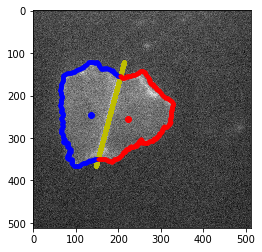

In [7]:
label = np.load('middle-act/level_set.npy')
I = np.load('middle-act/sample.npy')
I2 = np.copy(I)
I[label > 0] = 0
xo, yo = np.where(I > 0)

# rescale
need = I[I > 0]
nmax = max(need)
nmin = min(need)
distance = 180
for j in range(len(I)):
    for k in range(len(I)):
        if I[j, k] > 0:
            I[j, k] = I[j, k]*(distance/(nmax-nmin)) + 255 - (distance*nmax)/(nmax-nmin)

zc = zerocrossing(label)

# Sobel edge detection
I[I < 170] = 0
dx = ndimage.sobel(I, 0)  # horizontal derivative
dy = ndimage.sobel(I, 1)  # vertical derivative
new = np.hypot(dx, dy)  # magnitude
label2, num_features = scipy.ndimage.label(new)
for i in range(1, num_features + 1):
    temp = np.sum(label2 == i)
    if temp >= 10:
        label2[label2 == i] = -1

label2[label2 >= 0] = 1
xn, yn = np.where(label2 < 0)

# acquire points far from the zero-crossing points
index = []
for j in range(len(xn)):
    if np.min(np.sqrt((yn[j]-zc[:, 1])**2 + (xn[j]-zc[:, 0])**2)) > 25:
        index.append([xn[j], yn[j]])

index = unique(index)
index = np.asarray(index)
blank = np.zeros((np.shape(I)))
blank[index[:, 0], index[:, 1]] = 1
label2, num_features = ndimage.label(blank)
for i in range(1, num_features + 1):
    temp = np.sum(label2 == i)
    if temp >= 20:
        label2[label2 == i] = -1

label2[label2 >= 0] = 1
xb, yb = np.where(label2 < 0)

# linear regression
[flag, p] = lineardecision(xb, yb)
swing = []
if flag == 1:
    for j in range(len(xo)):
        if np.abs(np.polyval(p, xo[j])-yo[j]) < 1:
            swing.append([xo[j], yo[j]])
else:
    for j in range(len(yo)):
        if np.abs(np.polyval(p, yo[j])-xo[j]) < 1:
            swing.append([xo[j], yo[j]])

swing = unique(swing)
swing = np.asarray(swing)

# which side of the line are you in?
liberal = []
republican = []
for i, j in enumerate(zc):
    if flag == 1:
        if np.polyval(p, j[0])-j[1] > 0:
            liberal.append(j)
        else:
            republican.append(j)
    else:
        if np.polyval(p, j[1])-j[0] > 0:
            liberal.append(j)
        else:
            republican.append(j)

liberal = np.asarray(liberal)
republican = np.asarray(republican)
blue = np.concatenate((liberal, swing))
red = np.concatenate((republican, swing))
Hillary = [np.mean(blue[:, 0]), np.mean(blue[:, 1])]
Donald = [np.mean(red[:, 0]), np.mean(red[:, 1])]
plt.imshow(I2, 'gray')
if flag == 1:
    plt.plot(np.polyval(p, xo), xo, '.y')
else:
    plt.plot(yo, np.polyval(p, yo), '.y')

plt.plot(liberal[:, 1], liberal[:, 0], '.b')
plt.plot(republican[:, 1], republican[:, 0], '.r')
plt.plot(Hillary[1], Hillary[0], 'ob')
plt.plot(Donald[1], Donald[0], 'or')
plt.show()

np.save('middle-act/divide.npy', (liberal, Hillary, republican, Donald, swing))

restart another level set within the cell

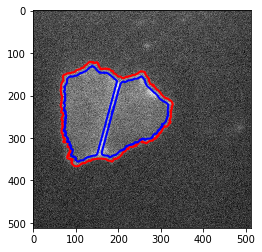

In [8]:
label = np.load('middle-act/level_set.npy')
I = np.load('middle-act/preprocessing.npy')
I2 = np.load('middle-act/sample.npy')
I[label > 0] = 0
xo, yo = np.where(I > 0)

# clear the others, keep the outline alive
liberal, Hillary, republican, Donald, swing = np.load('middle-act/divide.npy')
outline = []
for j in range(len(xo)):
    if np.min(np.sqrt((xo[j]-liberal[:, 0])**2 + (yo[j]-liberal[:, 1])**2)) < 10:
        outline.append([xo[j], yo[j]])
for j in range(len(xo)):
    if np.min(np.sqrt((xo[j]-republican[:, 0])**2 + (yo[j]-republican[:, 1])**2)) < 10:
        outline.append([xo[j], yo[j]])
for j in range(len(xo)):
    if np.min(np.sqrt((xo[j] - swing[:, 0]) ** 2 + (yo[j] - swing[:, 1]) ** 2)) < 5:
        outline.append([xo[j], yo[j]])

outline = unique(outline)
outline = np.asarray(outline)
new = np.zeros(np.shape(I))
new[label > 0] = 0
for j in range(len(outline)):
    new[outline[j, 0], outline[j, 1]] = I[outline[j, 0], outline[j, 1]]

row, col = I.shape
box1 = np.zeros((I.shape[0], I.shape[1]))
box2 = np.zeros((I.shape[0], I.shape[1]))
box1[int(Hillary[0]-2):int(Hillary[0]+2), int(Hillary[1]-2):int(Hillary[1]+2)] = 1
box2[int(Donald[0]-2):int(Donald[0]+2), int(Donald[1]-2):int(Donald[1]+2)] = 1

# level-set evolution
label1 = levelset(1, new, box1, 200, -1)
label2 = levelset(1, new, box2, 200, -1)
plt.imshow(I2, 'gray')
plt.contour(label, 0, colors='r', linewidths=2)
plt.contour(label1, 0, colors='b', linewidths=2)
plt.contour(label2, 0, colors='b', linewidths=2)
plt.show()

np.save('middle-act/relevelset', (label, label1, label2))

Locate the bright parts in the image and then analyze them 

C:\Users\wangj\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
C:\Users\wangj\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\wangj\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


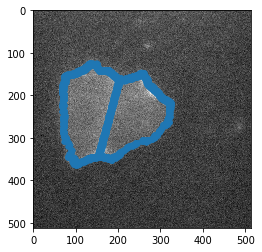

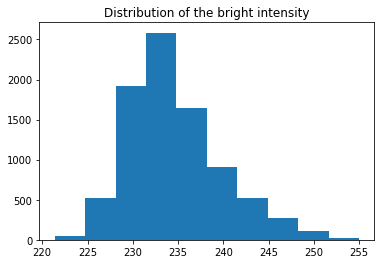

In [9]:
I = np.load('middle-act/sample.npy')
I2 = np.copy(I)
[label, label1, label2] = np.load('middle-act/relevelset.npy')
I[label > 0] = 0
I[label1 > 0] = 0
I[label2 > 0] = 0

# bright threshold
threshold = thresholding(I, 0, 200)  # threshold for the bright definition
brightx, brighty = np.where(I > threshold)
bright = np.asarray([brightx, brighty]).T

plt.imshow(I2, 'gray')
plt.hold(True)
plt.plot(bright[:, 1], bright[:, 0], '.')
plt.xlim([0, 512])
plt.ylim([512, 0])

plt.figure()
need = I[bright[:, 0], bright[:, 1]]
plt.hist(need)
plt.title('Distribution of the bright intensity')

plt.show()